**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from scipy.spatial.distance import euclidean

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.neighbors import KDTree

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors=2, algorithm='brute',metric='euc'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        return None
        
    
    def fit(self, X, y):
        self.features = X
        self.answers = y
        self.classes = np.unique(y)
    
                    
                
    def predict(self, X):
        if self.algorithm == 'kd_tree':
            tree = KDTree(self.features)
            distances, dist_args = tree.query(X,self.n_neighbors)
        else:
            #cosine_similarity
            #получаю матрицу евклидовых расстояний между каждым объектом из test и каждым объектом из train
            #Если train.shape (N,M), а test.shape=(L,M), то получится матрица (L,N)
            if self.metric == 'cosine':
                dist = 1 - cosine_similarity(X, self.features)
            else:
                dist = euclidean_distances(X, self.features)
            #получаю индексы К ближайших соседей в каждой строке, то есть матрицу (L,K). 
            dist_args = np.argsort(dist, axis=1)[:,:self.n_neighbors:] 
            #получаю расстояния К ближайших соседей в каждой строке, то есть матрицу (L,K). 
            distances = np.sort(dist, axis=1)[:,:self.n_neighbors:] 
            #К каждой стооке применяю вспомогательную функцию predict_class
        y=np.apply_along_axis(predict_class,1,dist_args,self.answers,distances)            
        return y    
    
    
def predict_class(args,y,distances):
    #получаю классы K ближайщих соседей
    pos_classes=y[args]
    #считаю сумму весов для каждого класса, где вес = 1/расстояние до очередного ближайщего соседа
    classes_dict=dict.fromkeys(pos_classes,0)
    for i in range(pos_classes.shape[0]):
            classes_dict[pos_classes[i]]+=1/(1+distances[i])
    #возвращаю класс с максимальным весом    
    return max(classes_dict)    
    
        
    
    
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [8]:
accuracy_score(y_test, my_clf_pred)

0.9333333333333333

In [9]:
accuracy_score(y_test, sklearn_pred )

0.9333333333333333

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [10]:
%time clf.fit(X_train, y_train)

Wall time: 971 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [11]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [12]:
%time clf.predict(X_test)

Wall time: 2 ms


array([0, 1, 1, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 1, 2])

In [13]:
%time my_clf.predict(X_test)

Wall time: 998 µs


array([0, 1, 1, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 1, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

Wall time: 3.97 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [17]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [18]:
%time clf.predict(X_test)

Wall time: 4 ms


array([0, 1, 2, 0, 2, 1, 0, 0, 2, 1, 0, 2, 1, 1, 2])

In [19]:
%time my_clf.predict(X_test)

Wall time: 998 µs


array([0, 1, 2, 0, 2, 1, 0, 0, 2, 1, 0, 2, 1, 1, 2])

In [20]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [21]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer 

vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [24]:
from sklearn.model_selection import cross_validate,cross_val_score

In [25]:
data_vectorized.shape , target.shape

((11314, 101631), (11314,))

In [26]:
clf = MyKNeighborsClassifier(n_neighbors=2,algorithm='brute')
res = cross_val_score(clf,data_vectorized,target,cv=3,scoring='accuracy')
res

array([0.15906681, 0.17024662, 0.17475471])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [27]:
import matplotlib.pyplot as plt

1

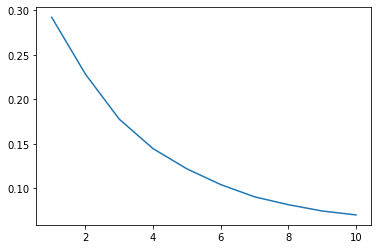

<Figure size 432x288 with 0 Axes>

In [28]:
max_n = 10

def best_k(max_n, X , y):
    res=[]
    for i in range(max_n):
        clf = MyKNeighborsClassifier(n_neighbors=i+1,algorithm='brute',metric='cosine')
        res.append(np.mean(cross_val_score(clf,X,y,cv=3,scoring='accuracy')))
    plt.plot(np.arange(1,max_n+1),res)
    plt.figure()
    return np.argmax(res)+1
    
best_k(max_n,data_vectorized,target)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

1

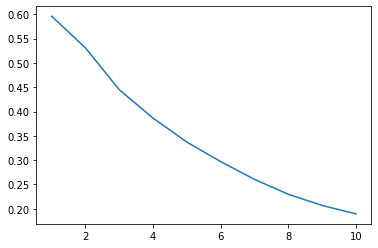

<Figure size 432x288 with 0 Axes>

In [29]:
vect = TfidfVectorizer()
data_vectorized = vect.fit_transform(data)
best_k(max_n,data_vectorized,target)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [30]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [31]:
data_test = newsgroups['data']
target_test = newsgroups['target']

In [32]:
vectorizer = TfidfVectorizer()
data_vectorized = vectorizer.fit_transform(data)
test_data_vectorized = vectorizer.transform(data_test)

clf = MyKNeighborsClassifier(n_neighbors=1,algorithm='brute',metric='cosine')
clf.fit(data_vectorized,target)
res = clf.predict(test_data_vectorized)
accuracy_score(res,target_test)

0.5088953797132236

результат плохой из-за проклятия размерности:с